In [2]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [16]:
data_dir = 'Resources/nasa_bearing/2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    #print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    #print(dataset)
    dataset_mean_abs = np.array(dataset.abs().mean())
    #print(len(dataset_mean_abs))
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

In [17]:
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.12.10.32.39,0.058333,0.071832,0.083242,0.043067
2004.02.12.10.42.39,0.058995,0.074006,0.084435,0.044541
2004.02.12.10.52.39,0.060236,0.074227,0.083926,0.044443
2004.02.12.11.02.39,0.061455,0.073844,0.084457,0.045081
2004.02.12.11.12.39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004.02.19.05.42.39,0.453335,0.161016,0.137440,0.119047
2004.02.19.05.52.39,0.337583,0.132400,0.144992,0.092125
2004.02.19.06.02.39,0.351111,0.152266,0.151299,0.100817
2004.02.19.06.12.39,0.001857,0.003732,0.003656,0.001786


In [18]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


<AxesSubplot:>

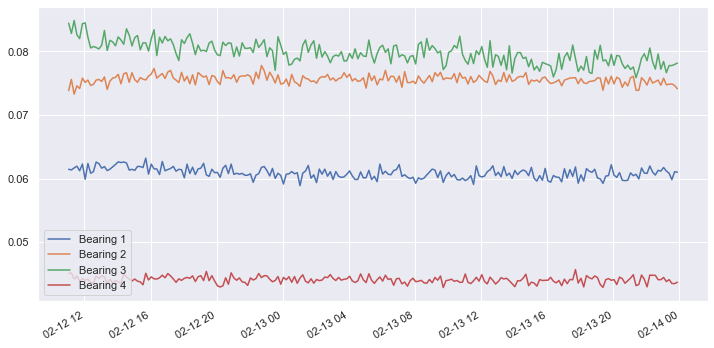

In [19]:
#splitting the training and test data
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize = (12,6))

In [20]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [21]:
X_train

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 11:02:39,0.594640,0.125020,0.953188,0.794650
2004-02-12 11:12:39,0.572777,0.515185,0.773329,0.807756
2004-02-12 11:22:39,0.642988,0.000000,1.000000,0.472299
2004-02-12 11:32:39,0.707427,0.290580,0.749966,0.644737
2004-02-12 11:42:39,0.542705,0.197430,0.682892,0.354536
...,...,...,...,...
2004-02-13 23:12:39,0.531622,0.326219,0.087451,0.332808
2004-02-13 23:22:39,0.451104,0.345965,0.212896,0.443161
2004-02-13 23:32:39,0.218776,0.356038,0.212484,0.229761
2004-02-13 23:42:39,0.504087,0.300491,0.232546,0.215409


In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [23]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [24]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [25]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [26]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [27]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [28]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [29]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)